In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Obviously this is a binary classfication problem, and the data sets are complex.
I decide to choose application_train as my main object.

In [3]:
train_set = pd.read_csv('./data/application_train.csv')
print(train_set.shape)
ts = train_set.drop(columns="TARGET")

(307511, 122)


There are 122 columns, it will cost a lot of time to understand the meaning of each column.
So the first step is to select the columns that interest me, and mine whether they are related to TARGET.

In [4]:
ts_col = ts.apply(pd.Series.nunique).sort_values()
ts_col.describe()
ts_col_less_2 = ts_col[ts_col.values<=2]
ts_col_less_2.count()

count       121.000000
mean       5749.256198
std       31531.353933
min           2.000000
25%           2.000000
50%          25.000000
75%        1097.000000
max      307511.000000
dtype: float64

36

We can see that there are 36 columns which only have two types of value, so we can first analyze the correlation between these features and TARGET. It should be noticed that whether there are missing value.

In [5]:
def calc_miss_prec(df):
    return df.isnull().sum()/len(df)

def stats_of_col(data_set, col_name):
    p = data_set[[col_name, 'TARGET']].groupby([col_name]).mean()
    p.sort_values(by='TARGET', ascending=False, inplace=True)
    print(p)
    return float(p.max() - p.min())

features = []
for c in ts_col_less_2.index:
    # if calc_miss_prec(train_set[c]) < 0.1:
        if stats_of_col(train_set, c) > 0.02:
            features.append(c)
features


                          TARGET
REG_CITY_NOT_WORK_CITY          
1                       0.106114
0                       0.073127
                    TARGET
FLAG_DOCUMENT_14          
0                 0.080869
1                 0.033223
              TARGET
FLAG_MOBIL          
1           0.080729
0           0.000000
                  TARGET
FLAG_EMP_PHONE          
1               0.086600
0               0.054003
                   TARGET
FLAG_WORK_PHONE          
1                0.096301
0                0.076851
                    TARGET
FLAG_CONT_MOBILE          
1                 0.080733
0                 0.078397
              TARGET
FLAG_PHONE          
0           0.084784
1           0.070357
                    TARGET
FLAG_DOCUMENT_18          
0                 0.080925
1                 0.056800
              TARGET
FLAG_EMAIL          
0           0.080846
1           0.078775
                    TARGET
FLAG_DOCUMENT_16          
0                 0.081046
1      

['REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_14',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'EMERGENCYSTATE_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_21',
 'NAME_CONTRACT_TYPE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13']

I counted columns with only two types of values, and calculated their proportion in TARGET. I selected the column with the proportion difference greater than 0.02 as the feature.

In [6]:
# calculate the proportion of missing
col_miss = []
ts_col_miss = [c for c in ts_col.index if ts_col[c] > 2]
for c in ts_col_miss:
    if calc_miss_prec(train_set[c]) > 0.5:
        col_miss.append(c)
train_set_miss = train_set[col_miss]
train_set_miss.replace(r"\w.*", 1, regex=True, inplace=True)
train_set_miss = train_set_miss.astype('str')
train_set_miss.replace(r'\d.*', 1, regex=True, inplace=True)
train_set_miss['TARGET'] = train_set['TARGET']



In [7]:
features_miss = []
for c in col_miss:
    if stats_of_col(train_set_miss, c) > 0.02:
        features_miss.append(c)
features_miss

                  TARGET
HOUSETYPE_MODE          
nan             0.091512
1               0.069870
                      TARGET
FONDKAPREMONT_MODE          
nan                 0.086188
1                   0.068919
                      TARGET
WALLSMATERIAL_MODE          
nan                 0.091281
1                   0.069815
                  TARGET
FLOORSMIN_MODE          
nan             0.086311
1               0.068950
                  TARGET
ELEVATORS_MODE          
nan             0.091006
1               0.069002
                  TARGET
ENTRANCES_MODE          
nan             0.091786
1               0.069517
                  TARGET
ELEVATORS_MEDI          
nan             0.091006
1               0.069002
                  TARGET
ENTRANCES_MEDI          
nan             0.091786
1               0.069517
                  TARGET
FLOORSMIN_MEDI          
nan             0.086311
1               0.068950
               TARGET
OWN_CAR_AGE          
nan          0.085000
1 

['HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE']

For columns with large missing, treat them as separate categories. The processing method is the same as above.

In [6]:
from sklearn.preprocessing import LabelEncoder
def plot_days_col(data_set, col):
    plt.figure()
    sns.kdeplot(data_set.loc[data_set['TARGET'] == 0, col], label = 'good')
    sns.kdeplot(data_set.loc[data_set['TARGET'] == 1, col], label = 'bad')
    plt.legend()
    plt.show()

ts_col_cont = [c for c in ts_col.index if ts_col[c] > 25]
le = LabelEncoder()
for c in ts_col_cont:
    if c in features:
        continue
    if isinstance(train_set[c][0], str):
        le.fit(train_set[c])
        train_set[c] = le.transform(train_set[c])
    # plot_days_col(train_set, c)
      


LabelEncoder()

Draw kdeplot using columns with continuous values and observe whether there are differences.
And select several columns with obvious differences as features:
- OBS_60_CNT_SOCIAL_CIRCLE
- OBS_30_CNT_SOCIAL_CIRCLE
- ORGANIZATION_TYPE
- OWN_CAR_AGE
- DAYS_LAST_PHONE_CHANGE
- DAYS_ID_PUBLISH
- DAYS_BIRTH
- DAYS_EMPLOYED  (noticed that there is a outlier)
- AMT_GOODS_PRICE
- AMT_CREDIT
- AMT_ANNUITY
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3

In [7]:
train_set['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

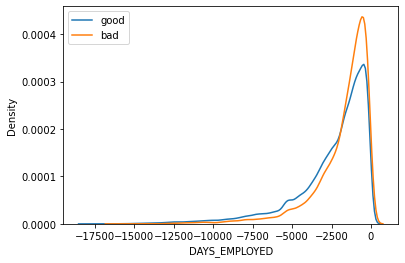

In [8]:
train_set['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
plot_days_col(train_set, 'DAYS_EMPLOYED')

Replace the outlier, it looks better.

In [99]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import gc
def qifei(train_set, test_set, features):
    labels = train_set['TARGET']
    train_set = train_set.drop(columns=['TARGET'])
    train_set = train_set[features]
    test_set = test_set[features]
    
    label_encoder = LabelEncoder()
    cat_indices = []
    for i, col in enumerate(train_set):
        if train_set[col].dtype == 'object':
            train_set[col] = label_encoder.fit_transform(np.array(train_set[col].astype(str)).reshape((-1,)))
            test_set[col] = label_encoder.transform(np.array(test_set[col].astype(str)).reshape((-1,)))

            cat_indices.append(i)
    # train_set = train_set.fillna(0)
    # test_set = test_set.fillna(0)
    # poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    # train_set = pd.DataFrame(poly.fit_transform(train_set), columns=poly.get_feature_names(fe))
    # test_set = pd.DataFrame(poly.fit_transform(test_set), columns=poly.get_feature_names(fe))
    # features = poly.get_feature_names(fe)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_set)
    train_set = scaler.transform(train_set)
    test_set = scaler.transform(test_set)
    print(len(features))
    print(train_set.shape)
    print(test_set.shape)
    # ts_col_cont = [c for c in ts_col.index if ts_col[c] > 25]
    # le = LabelEncoder()
    # for c in ts_col_cont:
    #     if c in features or c in features_miss:
    #         continue
    #     if isinstance(train_set[c][0], str):
    #         le.fit(train_set[c])
    #         train_set[c] = le.transform(train_set[c])
    k = KFold(n_splits = 5, shuffle = True, random_state = 66)
    imp_val = np.zeros(len(features))
    test_pred = np.zeros(test_set.shape[0])
    out_of_fold = np.zeros(train_set.shape[0])

    train_set = np.array(train_set)
    test_set = np.array(test_set)
    train_score = []
    valid_score = []
    for t, v in k.split(train_set):
        tf, tl = train_set[t], labels[t]
        vf, vl = train_set[v], labels[v]
        model = lgb.LGBMClassifier(n_estimators = 1000, 
                                    class_weight = 'balanced', learning_rate = 0.05, 
                                    reg_alpha = 0.1, reg_lambda = 0.1, 
                                    subsample = 0.8, n_jobs = -1, random_state = 66)
        model.fit(tf, tl, eval_metric = 'auc',
                  eval_set = [(vf, vl), (tf, tl)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)

        best_iteration = model.best_iteration_
        imp_val += model.feature_importances_ / k.n_splits
        
        test_pred += model.predict_proba(test_set, num_iteration = best_iteration)[:, 1] / k.n_splits

        out_of_fold[v] = model.predict_proba(vf, num_iteration = best_iteration)[:, 1]
        vs = model.best_score_['valid']['auc']
        ts = model.best_score_['train']['auc']
        
        valid_score.append(vs)
        train_score.append(ts)

        gc.enable()
        del model, tf, vf
        gc.collect()

    submission = pd.DataFrame({'TARGET': test_pred})
    feature_importances = pd.DataFrame({'feature': features, 'importance': imp_val})
    valid_auc = roc_auc_score(labels, out_of_fold)
    valid_score.append(valid_auc)
    train_score.append(np.mean(train_score))

    fold_names = list(range(5))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_score,
                            'valid': valid_score}) 
    
    return submission, feature_importances, metrics

In [89]:
train_sets = pd.read_csv('./data/application_train.csv')
test_sets = pd.read_csv('./data/application_test.csv')

# ----manual features--
train_sets['INCOME_PER_PERSON'] = train_sets['AMT_INCOME_TOTAL'] / (train_sets['CNT_CHILDREN'] + 1)
test_sets['INCOME_PER_PERSON'] = test_sets['AMT_INCOME_TOTAL'] / (test_sets['CNT_CHILDREN'] + 1)
train_sets['CREDIT_PER_PERSON'] = train_sets['AMT_CREDIT'] / (train_sets['CNT_CHILDREN'] + 1)
test_sets['CREDIT_PER_PERSON'] = test_sets['AMT_CREDIT'] / (test_sets['CNT_CHILDREN'] + 1)
train_sets['AMT_DEBT_RATE'] = train_sets['AMT_ANNUITY'] / train_sets['AMT_CREDIT']
test_sets['AMT_DEBT_RATE'] = test_sets['AMT_ANNUITY'] / test_sets['AMT_CREDIT']
# -------bureau--------
bur = pd.read_csv('./data/bureau.csv')
credit_type = bur[['SK_ID_CURR', 'CREDIT_TYPE']]
credit_days = bur[['SK_ID_CURR', 'DAYS_CREDIT']]
credit_type = pd.get_dummies(credit_type)
credit_type = credit_type.groupby(['SK_ID_CURR'], as_index=False).sum()

credit_days = bur[['SK_ID_CURR', 'DAYS_CREDIT']]
credit_cnt = credit_days.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count().reset_index(name='CNT')
credit_days['DAYS_DIFF'] = credit_days.sort_values('DAYS_CREDIT').groupby('SK_ID_CURR')['DAYS_CREDIT'].diff()
DAYS_CREDIT_MIN = credit_days.groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
DAYS_DIFF_MIN = credit_days.groupby('SK_ID_CURR')['DAYS_DIFF'].min()
bur_days = pd.merge(DAYS_CREDIT_MIN, DAYS_DIFF_MIN, on='SK_ID_CURR')
bur_days = pd.merge(bur_days, credit_cnt, on='SK_ID_CURR')

is_overdue = bur[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']]
is_overdue['IS_OVERDUE'] = is_overdue['AMT_CREDIT_SUM_OVERDUE'].apply(lambda x:1 if x>0 else 0)
is_overdue = is_overdue.groupby('SK_ID_CURR').sum()
is_overdue = is_overdue.drop(columns='AMT_CREDIT_SUM_OVERDUE')

train_sets = pd.merge(train_sets, credit_type, on='SK_ID_CURR', how='left')
test_sets = pd.merge(test_sets, credit_type, on='SK_ID_CURR', how='left')
train_sets = pd.merge(train_sets, bur_days, on='SK_ID_CURR', how='left')
test_sets = pd.merge(test_sets, bur_days, on='SK_ID_CURR', how='left')
train_sets = pd.merge(train_sets, is_overdue, on='SK_ID_CURR', how='left')
test_sets = pd.merge(test_sets, is_overdue, on='SK_ID_CURR', how='left')
fe_bureau = credit_type.columns.values.tolist() + bur_days.columns.values.tolist() + is_overdue.columns.values.tolist()
fe_bureau = [x for x in fe_bureau if x != 'SK_ID_CURR']
print('features from bureau: ', fe_bureau)

# ---------------------

# -------building------
BUILDING_COL = ['APARTMENTS_AVG',
'BASEMENTAREA_AVG',
'YEARS_BEGINEXPLUATATION_AVG',
'YEARS_BUILD_AVG',
'COMMONAREA_AVG',
'ELEVATORS_AVG',
'ENTRANCES_AVG',
'FLOORSMAX_AVG',
'FLOORSMIN_AVG',
'LANDAREA_AVG',
'LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG',
'NONLIVINGAPARTMENTS_AVG',
'NONLIVINGAREA_AVG',
'APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE',
'APARTMENTS_MEDI',
'BASEMENTAREA_MEDI',
'YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BUILD_MEDI',
'COMMONAREA_MEDI',
'ELEVATORS_MEDI',
'ENTRANCES_MEDI',
'FLOORSMAX_MEDI',
'FLOORSMIN_MEDI',
'LANDAREA_MEDI',
'LIVINGAPARTMENTS_MEDI',
'LIVINGAREA_MEDI',
'NONLIVINGAPARTMENTS_MEDI',
'NONLIVINGAREA_MEDI',
'TOTALAREA_MODE']
train_sets['BUILDING_INFORMATION'] = train_sets[BUILDING_COL].sum(axis=1)
test_sets['BUILDING_INFORMATION'] = test_sets[BUILDING_COL].sum(axis=1)




features from bureau:  ['CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit', 'CREDIT_TYPE_Loan for business development', 'CREDIT_TYPE_Loan for purchase of shares (margin lending)', 'CREDIT_TYPE_Loan for the purchase of equipment', 'CREDIT_TYPE_Loan for working capital replenishment', 'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan', 'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan', 'CREDIT_TYPE_Unknown type of loan', 'DAYS_CREDIT', 'DAYS_DIFF', 'CNT', 'IS_OVERDUE']


In [100]:
fe = features + fe_bureau + [
    'CNT_CHILDREN',
    'NAME_EDUCATION_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
    'OWN_CAR_AGE',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'AMT_GOODS_PRICE',
    'AMT_CREDIT',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'BUILDING_INFORMATION',
    'INCOME_PER_PERSON',
    'CREDIT_PER_PERSON',
    'AMT_DEBT_RATE',
    ]

submission, fi, metrics = qifei(train_sets, test_sets, fe)
# print('metrics')
print(metrics)

58
(307511, 58)
(48744, 58)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.799364	train's binary_logloss: 0.546691	valid's auc: 0.761008	valid's binary_logloss: 0.561224
Early stopping, best iteration is:
[285]	train's auc: 0.811855	train's binary_logloss: 0.533845	valid's auc: 0.761399	valid's binary_logloss: 0.553583
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798142	train's binary_logloss: 0.548133	valid's auc: 0.768769	valid's binary_logloss: 0.560114
Early stopping, best iteration is:
[274]	train's auc: 0.809221	train's binary_logloss: 0.536993	valid's auc: 0.769206	valid's binary_logloss: 0.553267
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.799029	train's binary_logloss: 0.547155	valid's auc: 0.76222	valid's binary_logloss: 0.559851
[400]	train's auc: 0.82618	train's binary_logloss: 0.519016	valid's auc: 0.763001	valid's binary_logloss: 0.542958
Early stopping, best i

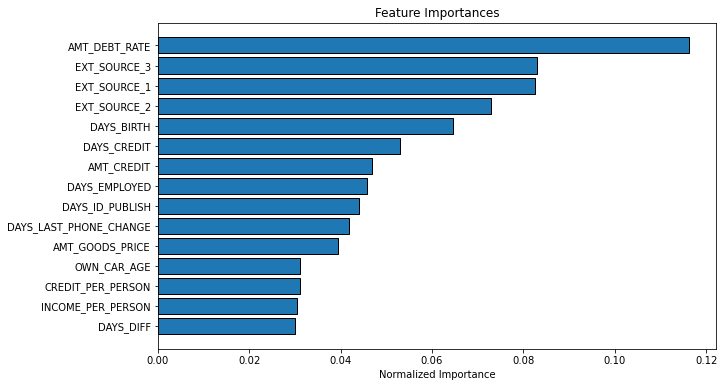

In [101]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
fi_sorted = plot_feature_importances(fi)

In [102]:
submission.to_csv('submission_data.csv')